## P6
Małgorzata Kurcjusz-Gzowska 

In [1]:
#%matplotlib notebook

In [2]:
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import networkx as nx
import numpy as np
import itertools

from scipy.stats import hypergeom,binom, poisson
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image, display


In [3]:

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter

#### Exercise 1 Implement BA algorithm.

In [33]:
def BA_graph(T=500, m0=5, m=3):
    degrees = np.zeros(m0, dtype=int)
    edges = [] # list of edges (u, v)
    history = [] # snapshots of edges after each step

    # initial fully connected graph (clique on m0 nodes)
    for i in range(m0):
        for j in range(i + 1, m0):
            degrees[i] += 1
            degrees[j] += 1
            edges.append((i, j))

    # list of "targets" with multiplicities proportional to degree
    targets = []
    for i, k in enumerate(degrees):
        targets.extend([i] * k)

 
    
    for t in range(m0, T):
        # add new node
        degrees = np.append(degrees, 0)
        new_node = t

        # choose m distinct existing nodes with probability - degree
        chosen = np.random.choice(targets, size=m, replace=False)

        
        for v in chosen:
            degrees[v] += 1
            degrees[new_node] += 1


            targets.append(v)
            targets.append(new_node)

    
            edges.append((new_node, v))

        # store copy of edge list for this time step
        history.append(edges.copy())

    return degrees, history



def BA_degrees_only(T=500, m0=5, m=3):
    degrees, _ = BA_graph(T=T, m0=m0, m=m)
    return degrees


In [19]:
deg_test, hist_test = BA_graph(T=20, m0=5, m=3)
print("Degrees:", deg_test)
print("History length:", len(hist_test))

Degrees: [ 9  7  6  8 10 10  7  9  4  5  4  5  5  3  3  3  3  3  3  3]
History length: 15


#### Exercise 2. Use it to create an animation of a growing graph.

In [20]:
def BA_animation_gif(T=200, m0=5, m=3, filename="ba_animation.gif"):

    _, history = BA_graph(T=T, m0=m0, m=m)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.axis("off")

    # fixed layout for all frames
    G_layout = nx.Graph()
    G_layout.add_nodes_from(range(T))
    pos = nx.spring_layout(G_layout, seed=0)

    def update(frame):
        ax.clear()
        ax.axis("off")

        G = nx.Graph()
        G.add_nodes_from(range(T))
        G.add_edges_from(history[frame])

        nx.draw(G, pos, ax=ax, node_size=40, width=0.7)
        ax.set_title(f"BA model – step {frame + 1}")

    ani = FuncAnimation(fig, update, frames=len(history), interval=100)

    # save as GIF using PillowWriter (no ffmpeg required)
    writer = PillowWriter(fps=10)
    ani.save(filename, writer=writer)
    plt.close(fig)

    print(f"Animation saved to: {filename}")
    display(Image(filename))


Animation saved to: ba_animation.gif


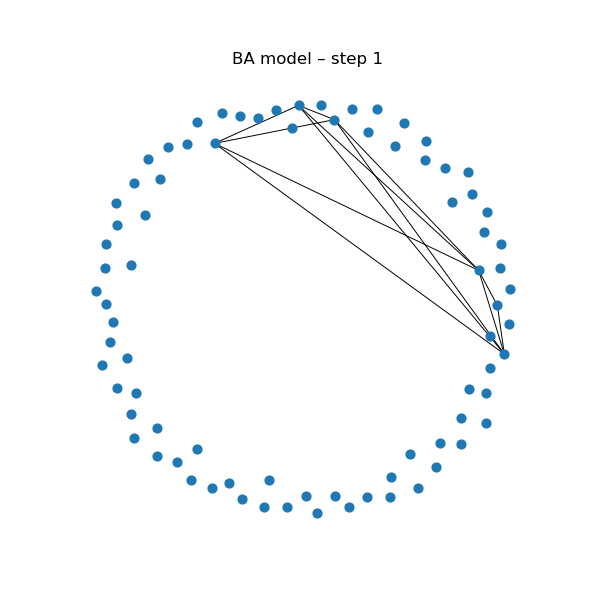

In [6]:
BA_animation_gif(T=80, m0=5, m=2, filename="ba_animation.gif")

#### Exercise 3. Plot the (averaged) histogram of the degree distribution at time t.

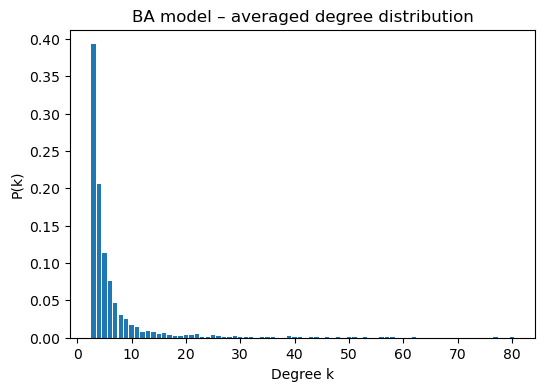

In [21]:
def averaged_degree_histogram(T=5000, m0=5, m=3, repeats=20):
    all_degrees = []

    for _ in range(repeats):
        degrees, _ = BA_graph(T=T, m0=m0, m=m)
        all_degrees.extend(degrees)

    all_degrees = np.array(all_degrees)
    vals, counts = np.unique(all_degrees, return_counts=True)
    prob = counts / counts.sum()

    plt.figure(figsize=(6, 4))
    plt.bar(vals, prob, width=0.8)
    plt.xlabel("Degree k")
    plt.ylabel("P(k)")
    plt.title("BA model – averaged degree distribution")
    plt.show()

    return vals, prob

vals, prob = averaged_degree_histogram(T=200, m0=5, m=3, repeats=10)

#### Exercise 4. Find the alpha coefficient for the data from the previous tasks. Does it agree with our theoretical result from the lecture? 

In [31]:
def estimate_alpha_ccdf(degrees, k_min=5):
    degrees = np.array(degrees)
    degrees = degrees[degrees >= k_min] # use tail only

    
    k = np.sort(degrees)

    # CCDF: P(K >= x)
    ccdf = 1 - np.arange(len(k)) / len(k)

    # log-log fitting
    x = np.log(k)
    y = np.log(ccdf)

    a, b = np.polyfit(x, y, 1)
    alpha = 1 - a # CCDF slope relation: slope = -(alpha - 1)

    # Plot
    plt.figure(figsize=(6, 4))
    plt.scatter(k, ccdf, s=10)
    plt.plot(k, np.exp(a * x + b), 'r--', label=f"Fit: alpha ≈ {alpha:.2f}",color="salmon")

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("k")
    plt.ylabel("P(K ≥ k)")
    plt.title("BA model – CCDF tail fit")
    plt.legend()
    plt.show()

    return alpha
# funkcja przeżycia

/var/folders/xg/gdrq_vp93cj1ps_x39psl1_00000gn/T/ipykernel_7098/4227155917.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(k, np.exp(a * x + b), 'r--', label=f"Fit: alpha ≈ {alpha:.2f}",color="salmon")


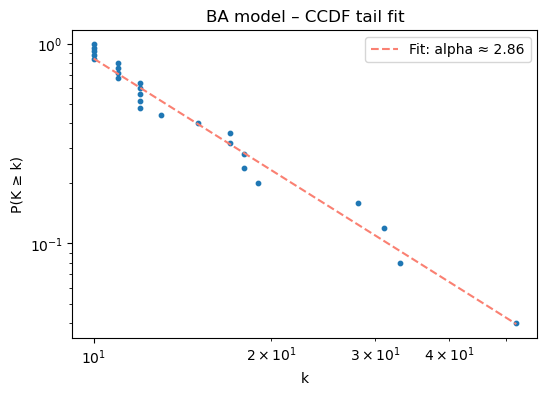

Estimated alpha: 2.8607162328755047


In [32]:
degrees, _ = BA_graph(T=200, m0=5, m=3)
alpha = estimate_alpha_ccdf(degrees, k_min=10)
print("Estimated alpha:", alpha)

#### Exercise 5. Ceck with simulations relation ki(t). Compare the predictions of the obtained formulas with the "empirical" data from simulations.

Birth time of node 100 = 100


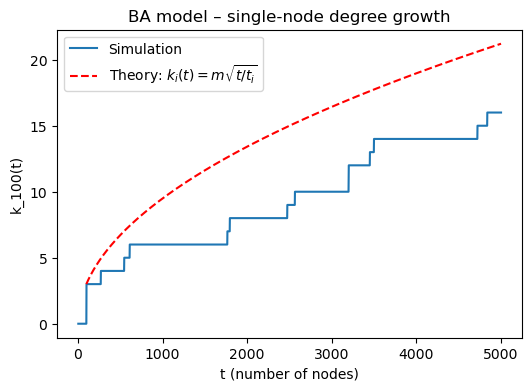

In [23]:
def BA_track_node(T=5000, m0=5, m=3, track_node=100):
    degrees = np.zeros(m0, dtype=int)
    edges = []

    for i in range(m0):
        for j in range(i + 1, m0):
            degrees[i] += 1
            degrees[j] += 1
            edges.append((i, j))

    targets = []
    for i, k in enumerate(degrees):
        targets.extend([i] * k)

    # birth times: node index == its birth time
    # initial nodes are born at times 0..m0-1
    birth_time = {i: i for i in range(m0)}

    times = []
    k_track = []

    # record initial state if needed
    times.append(m0)
    k_track.append(degrees[track_node] if track_node < len(degrees) else 0)

    for t in range(m0, T):
        degrees = np.append(degrees, 0)
        new_node = t
        birth_time[new_node] = t

        chosen = np.random.choice(targets, size=m, replace=False)
        for v in chosen:
            degrees[v] += 1
            degrees[new_node] += 1
            targets.append(v)
            targets.append(new_node)

        times.append(t + 1)  # number of nodes after adding the new one
        if track_node < len(degrees):
            k_track.append(degrees[track_node])
        else:
            k_track.append(0)

    times = np.array(times)
    k_track = np.array(k_track)
    t_i = birth_time.get(track_node, None)
    return times, k_track, t_i


# example
T = 5000
m0 = 5
m = 3
track_node = 100

times, k_track, t_i = BA_track_node(T=T, m0=m0, m=m, track_node=track_node)

print("Birth time of node", track_node, "=", t_i)

# theoretical prediction: k_i(t) = m * sqrt(t / t_i)
# We restrict to times >= t_i (after the node exists)
mask = times >= max(t_i, m0)
t_th = times[mask]
k_th = m * np.sqrt(t_th / t_i)

plt.figure(figsize=(6, 4))
plt.plot(times, k_track, label="Simulation")
plt.plot(t_th, k_th, 'r--', label=r"Theory: $k_i(t)=m\sqrt{t/t_i}$") # zapis z chatem gpt
plt.xlabel("t (number of nodes)")
plt.ylabel(f"k_{track_node}(t)")
plt.title("BA model – single-node degree growth")
plt.legend()
plt.show()


#### P6.1 Fill the gaps in the following derivation. [1P]

#### P6.2 Fill the gaps in the following derivation. [1.5P]

#### P6.3 Check with simulation results obtained for model A [1.5P]

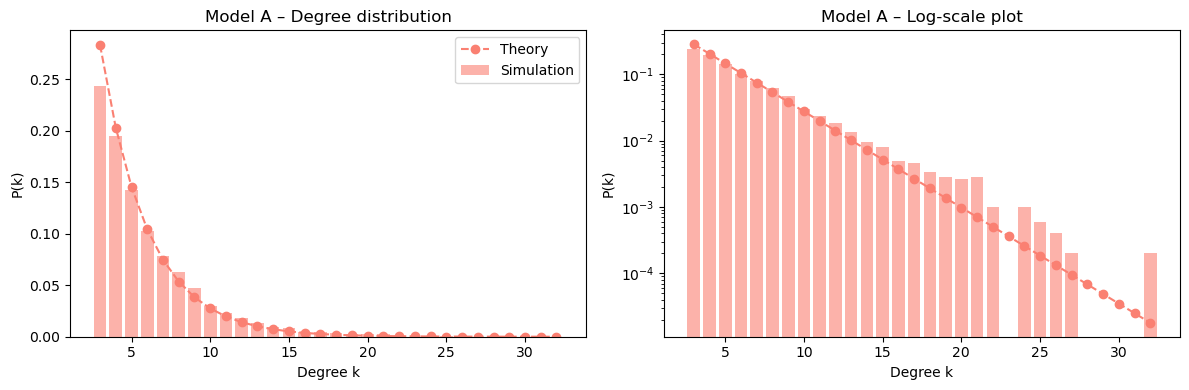

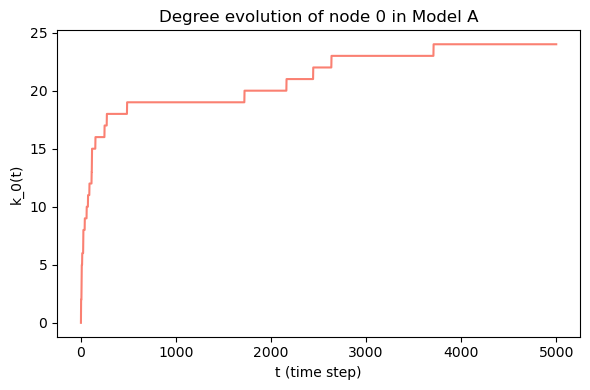

In [7]:
m0 = 5 # initial nodes
m = 3 # edges added by each new node
T = 5000 # new nodes 

# initial degrees of starting nodes
degrees = [0] * m0

# track degree evolution for node 0
ki_history = [degrees[0]] ###########

#  the initial nodes into  ring
for i in range(m0):
    
    j = (i + 1) % m0
    degrees[i] += 1
    degrees[j] += 1


for _ in range(T):
    new_node = len(degrees)
    degrees.append(0)

    targets = np.random.choice(new_node, size=m, replace=False)

    for v in targets:
        degrees[v] += 1
        degrees[new_node] += 1

    ki_history.append(degrees[0]) ###########


degrees = np.array(degrees)


# empirical degree distribution
vals, counts = np.unique(degrees, return_counts=True)
prob_emp = counts / counts.sum()

# theoretical exponential distribution
k_min = m
k_theory = np.arange(k_min, vals.max() + 1)
P_cont = (np.e / m) * np.exp(-k_theory / m)
P_disc = P_cont / P_cont.sum() # normalize to sum to 1


fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# degree dist
axes[0].bar(vals, prob_emp, alpha=0.6, label="Simulation",color="salmon")
axes[0].plot(k_theory, P_disc, 'o--', label="Theory", color="salmon")
axes[0].set_xlabel("Degree k")
axes[0].set_ylabel("P(k)")
axes[0].set_title("Model A – Degree distribution")
axes[0].legend()
# log plot
axes[1].bar(vals, prob_emp, alpha=0.6,color="salmon")
axes[1].plot(k_theory, P_disc, 'o--',color="salmon")
axes[1].set_yscale('log')
axes[1].set_xlabel("Degree k")
axes[1].set_ylabel("P(k)")
axes[1].set_title("Model A – Log-scale plot")

plt.tight_layout()
plt.show()

#ki(t) - tylko ten wykres ############
plt.figure(figsize=(6,4))
plt.plot(ki_history, color="salmon")
plt.xlabel("t (time step)")
plt.ylabel("k_0(t)")
plt.title("Degree evolution of node 0 in Model A")
plt.tight_layout()
plt.show()

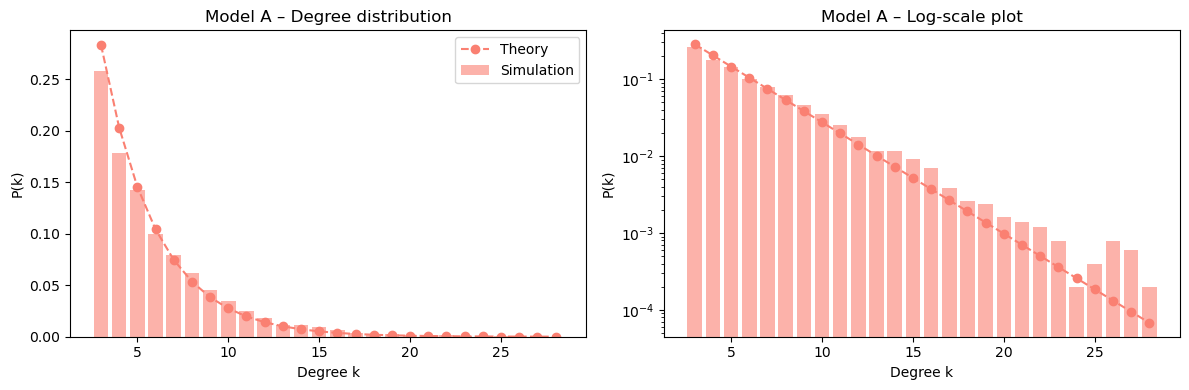

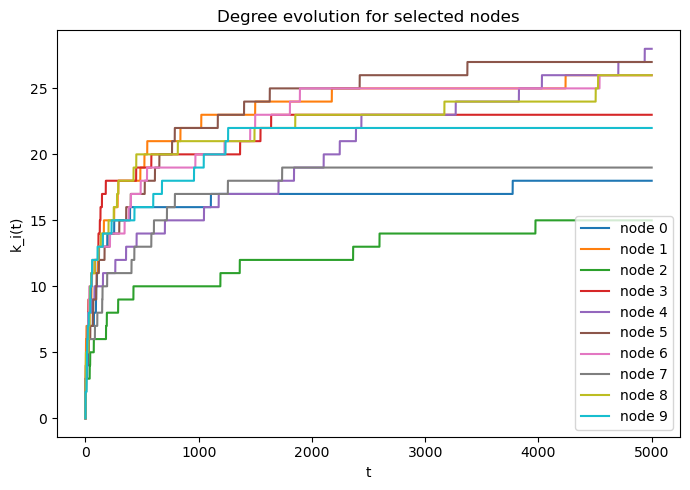

In [13]:
m0 = 10 # initial nodes
m = 3 # edges added by each new node
T = 5000 # new nodes 

# initial degrees of starting nodes
degrees = [0] * m0

# track degree evolution for node 0
#ki_history = [degrees[0]] ###########
nodes_to_track = [0, 1, 2, 3,  4, 5,6,7,8, 9]  
ki_history = {node: [] for node in nodes_to_track}
for node in nodes_to_track:
    ki_history[node].append(degrees[node])

#  the initial nodes into  ring
for i in range(m0):
    
    j = (i + 1) % m0
    degrees[i] += 1
    degrees[j] += 1


for _ in range(T):
    new_node = len(degrees)
    degrees.append(0)

    targets = np.random.choice(new_node, size=m, replace=False)

    for v in targets:
        degrees[v] += 1
        degrees[new_node] += 1

    #ki_history.append(degrees[0]) ###########
    for node in nodes_to_track:
        ki_history[node].append(degrees[node])


degrees = np.array(degrees)


# empirical degree distribution
vals, counts = np.unique(degrees, return_counts=True)
prob_emp = counts / counts.sum()

# theoretical exponential distribution
k_min = m
k_theory = np.arange(k_min, vals.max() + 1)
P_cont = (np.e / m) * np.exp(-k_theory / m)
P_disc = P_cont / P_cont.sum() # normalize to sum to 1


fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# degree dist
axes[0].bar(vals, prob_emp, alpha=0.6, label="Simulation",color="salmon")
axes[0].plot(k_theory, P_disc, 'o--', label="Theory", color="salmon")
axes[0].set_xlabel("Degree k")
axes[0].set_ylabel("P(k)")
axes[0].set_title("Model A – Degree distribution")
axes[0].legend()
# log plot
axes[1].bar(vals, prob_emp, alpha=0.6,color="salmon")
axes[1].plot(k_theory, P_disc, 'o--',color="salmon")
axes[1].set_yscale('log')
axes[1].set_xlabel("Degree k")
axes[1].set_ylabel("P(k)")
axes[1].set_title("Model A – Log-scale plot")

plt.tight_layout()
plt.show()

#ki(t) - tylko ten wykres ############
plt.figure(figsize=(7,5))
for node in nodes_to_track:
    plt.plot(ki_history[node], label=f"node {node}")
plt.xlabel("t")
plt.ylabel("k_i(t)")
plt.title("Degree evolution for selected nodes")
plt.legend()
plt.tight_layout()
plt.show()


#### P6.4 Check with simulation results obtained for model B [1.5P]

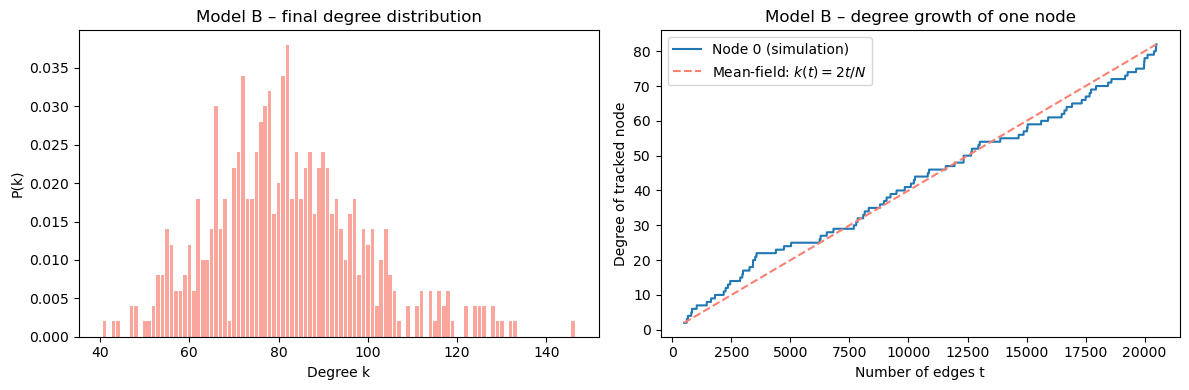

Final average degree: 82.0
Final degree standard deviation: 17.048049741832642


In [15]:
N = 500 # number of nodes
T = 20000 # number of added edges 
track_node = 0 # index of node whose degree we track over time


# initial network simple ring so all nodes start with degree 2
degrees = np.zeros(N, dtype=int)

# I create ring (0-1-2-...-N-1-0)
for i in range(N):
    j = (i + 1) % N
    degrees[i] += 1
    degrees[j] += 1

# number of edges at the start
edges0 = N  # ring has N edges
total_edges = edges0

# store degree of one node over time
k_track = [degrees[track_node]]
times = [total_edges]   # time measured as total number of edges



#growth
for step in range(T):
    # current total degree = 2 * number of edges
    total_degree = degrees.sum()

    # first endpoint preferential attachment 
    # if all degrees are zero (edge case), choose uniformly
    if total_degree == 0:
        first = np.random.randint(N)
    else:
        p_pref = degrees / total_degree
        first = np.random.choice(N, p=p_pref)

    # second endpoint uniform among all other nodes 
    second = np.random.randint(N - 1)
    if second >= first:
        second += 1 # shift to avoid 'first'

    # update degrees
    degrees[first] += 1
    degrees[second] += 1
    total_edges += 1

    # save tracked node degree
    k_track.append(degrees[track_node])
    times.append(total_edges)



# empirical degree distribution

vals, counts = np.unique(degrees, return_counts=True)
prob_emp = counts / counts.sum()


# mean-field prediction for a node
# k_i(t) ≈ (2 / N) * t  (for large N, ignoring small corrections)
# here t is total number of edges
times_arr = np.array(times)
k_theory = (2.0 / N) * times_arr


fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# degree dist
axes[0].bar(vals, prob_emp, alpha=0.7, color="salmon")
axes[0].set_xlabel("Degree k")
axes[0].set_ylabel("P(k)")
axes[0].set_title("Model B – final degree distribution")
# 
axes[1].plot(times_arr, k_track, label=f"Node {track_node} (simulation)")
axes[1].plot(times_arr, k_theory, '--', label=r"Mean-field: $k(t)=2t/N$", color="salmon")
axes[1].set_xlabel("Number of edges t")
axes[1].set_ylabel("Degree of tracked node")
axes[1].set_title("Model B – degree growth of one node")
axes[1].legend()

plt.tight_layout()
plt.show()

print("Final average degree:", degrees.mean())
print("Final degree standard deviation:", degrees.std())


#### P6.5 How to derive distribution in model B? [2P]